# 15. RNN과 CNN을 사용한 시퀀스 처리

In [2]:
import sys
print(sys.executable)

/usr/local/bin/python3


In [3]:
# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

## 15.1 순환 뉴런과 순환 층

### 15.1.1 메모리 셀

### 15.1.2 입력과 출력 시퀀스

## 15.2 RNN 훈련하기

## 15.3 시계열 예측하기

In [4]:
import pandas as pd
from pathlib import Path

path = Path('../datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals_20231023.csv')
df = pd.read_csv(path, parse_dates=['service_date'])
df.columns = ['date', 'day_type', 'bus', 'rail', 'total']
df = df.sort_values('date').set_index('date')
df = df.drop('total', axis=1)
df = df.drop_duplicates()

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


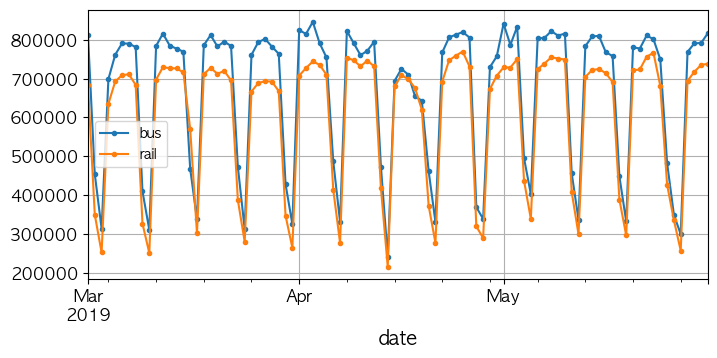

In [6]:
df['2019-03':'2019-05'].plot(grid=True, marker='.', figsize=(8, 3.5))
plt.show()

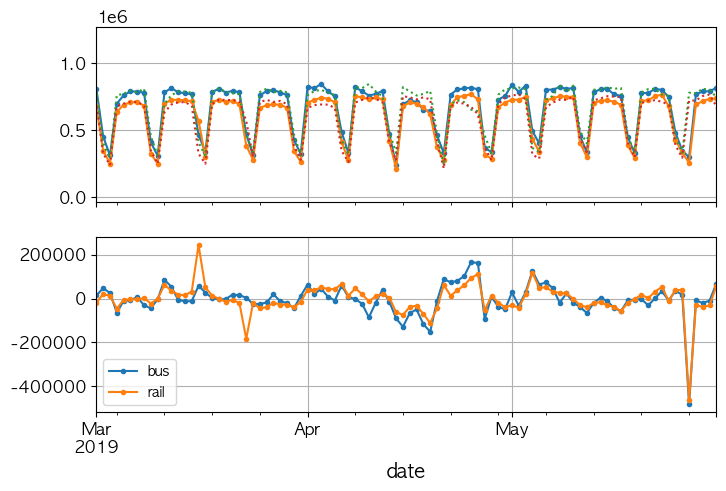

In [7]:
diff_7 = df[['bus', 'rail']].diff(7)['2019-03':'2019-05']

fig, axs = plt.subplots(2, 1, sharex = True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker='.')
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=':')
diff_7.plot(ax=axs[1], grid=True, marker='.')
plt.show()

In [8]:
list(df.loc['2019-05-25':'2019-05-27']['day_type'])

['A', 'U', 'U']

In [9]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [10]:
targets = df[['bus', 'rail']]['2019-03':'2019-05']
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

/var/folders/jd/_tlvgz1d22x3k8jpbtplqcsh0000gn/T/ipykernel_1384/382204260.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample('M').mean()


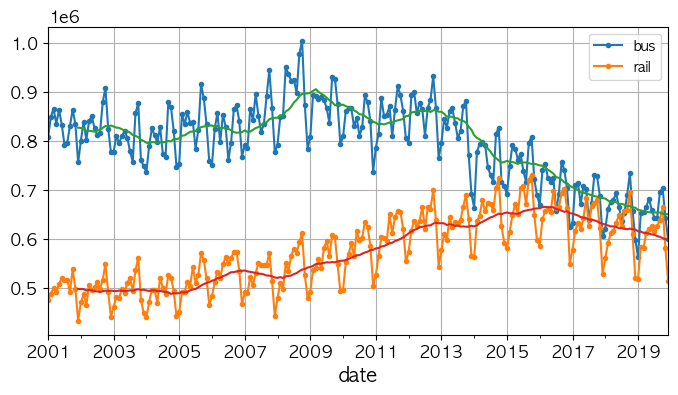

In [11]:
period = slice('2001', '2019')
df_monthly = df.resample('M').mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker='.')
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

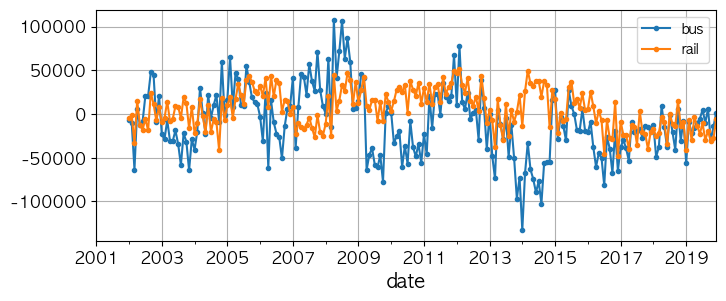

In [12]:
df_monthly.diff(12)[period].plot(grid=True, marker='.', figsize=(8, 3))
plt.show()

### 15.3.1 ARMA 모델

In [14]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = '2019-01-01', '2019-05-31'
rail_series = df.loc[origin:today]['rail'].asfreq('D')
model = ARIMA(rail_series, order = (1, 0, 0), seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()
y_pred

2019-06-01    427758.62641
Freq: D, dtype: float64

In [15]:
origin, start_date, end_date = '2019-01-01', '2019-03-01', '2019-05-31'
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]['rail'].asfreq('D')
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today], order=(1,0,0), seasonal_order=(0, 1, 1, 7))
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index = time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae

32040.720089453378

### 15.3.2 머신러닝 모델을 위한 데이터 준비하기

In [22]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],
    sequence_length=3,
    batch_size=2
)

2023-10-24 17:57:17.216438: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-10-24 17:57:17.216460: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-10-24 17:57:17.216466: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-10-24 17:57:17.216524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-24 17:57:17.216558: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [18]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f'{element}', end=' ')
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [28]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [29]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [30]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [31]:
rail_train = df['rail']['2016-01':'2018-12'] / 1e6
rail_valid = df['rail']['2019-01':'2019-05'] / 1e6
rail_test = df['rail']['2019-06':] / 1e6

In [32]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

### 15.3.3 선형 모델로 예측하기

In [33]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape = [seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500


2023-10-24 17:58:01.764460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 11ms/step - loss: 0.1202 - mae: 0.3923 - val_loss: 0.0091 - val_mae: 0.1051
Epoch 2/500
10/33 [========>.....................] - ETA: 0s - loss: 0.0228 - mae: 0.1754

2023-10-24 17:58:02.211548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 0s 7ms/step - loss: 0.0190 - mae: 0.1545 - val_loss: 0.0126 - val_mae: 0.1299
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0091 - mae: 0.1021 - val_loss: 0.0092 - val_mae: 0.1061
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0075 - mae: 0.0915 - val_loss: 0.0059 - val_mae: 0.0733
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0064 - mae: 0.0831 - val_loss: 0.0054 - val_mae: 0.0702
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0060 - mae: 0.0796 - val_loss: 0.0063 - val_mae: 0.0832
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0057 - mae: 0.0776 - val_loss: 0.0049 - val_mae: 0.0661
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0053 - mae: 0.0746 - val_loss: 0.0056 - val_mae: 0.0788
Epoch 9/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0054 - mae: 0.0779 -

### 15.3.4 간단한 RNN으로 예측하기

In [25]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape = [None, 1])
])

In [37]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [28]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 3s 30ms/step - loss: 0.0137 - mae: 0.1260 - val_loss: 0.0033 - val_mae: 0.0625
Epoch 2/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0055 - mae: 0.0796 - val_loss: 0.0043 - val_mae: 0.0737
Epoch 3/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0037 - mae: 0.0568 - val_loss: 0.0027 - val_mae: 0.0449
Epoch 4/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0036 - mae: 0.0546 - val_loss: 0.0018 - val_mae: 0.0336
Epoch 5/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0032 - mae: 0.0514 - val_loss: 0.0026 - val_mae: 0.0491
Epoch 6/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0032 - mae: 0.0518 - val_loss: 0.0020 - val_mae: 0.0351
Epoch 7/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0032 - mae: 0.0517 - val_loss: 0.0035 - val_mae: 0.0624
Epoch 8/500
33/33 [==============================] - 1s 21ms/step - loss: 0.

28489.93055522442

### 15.3.5 심층 RNN으로 예측하기

In [30]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [32]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 12s 110ms/step - loss: 0.0117 - mae: 0.1130 - val_loss: 0.0045 - val_mae: 0.0742
Epoch 2/500
33/33 [==============================] - 4s 131ms/step - loss: 0.0064 - mae: 0.0831 - val_loss: 0.0020 - val_mae: 0.0410
Epoch 3/500
33/33 [==============================] - 3s 80ms/step - loss: 0.0044 - mae: 0.0627 - val_loss: 0.0024 - val_mae: 0.0494
Epoch 4/500
33/33 [==============================] - 2s 44ms/step - loss: 0.0044 - mae: 0.0637 - val_loss: 0.0045 - val_mae: 0.0736
Epoch 5/500
33/33 [==============================] - 1s 43ms/step - loss: 0.0043 - mae: 0.0616 - val_loss: 0.0024 - val_mae: 0.0425
Epoch 6/500
33/33 [==============================] - 1s 43ms/step - loss: 0.0041 - mae: 0.0602 - val_loss: 0.0023 - val_mae: 0.0455
Epoch 7/500
33/33 [==============================] - 2s 46ms/step - loss: 0.0038 - mae: 0.0566 - val_loss: 0.0049 - val_mae: 0.0806
Epoch 8/500
33/33 [==============================] - 1s 43ms/step - loss:

KeyboardInterrupt: ignored

### 15.3.6 다변량 시계열 예측하기

In [19]:
df_mulvar = df[['bus', 'rail']] / 1e6
df_mulvar['next_day_type'] = df['day_type'].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar)
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


In [20]:
mulvar_train = df_mulvar['2016-01':'2018-12']
mulvar_valid = df_mulvar['2019-01':'2019-05']
mulvar_test = df_mulvar['2019-06']

/var/folders/jd/_tlvgz1d22x3k8jpbtplqcsh0000gn/T/ipykernel_1384/2274709312.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  mulvar_test = df_mulvar['2019-06']


In [34]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train['rail'][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid['rail'][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [35]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

### 15.3.7 여러 타임 스텝 앞 예측하기

In [38]:
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis = 1)

2023-10-24 18:01:42.195885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 207ms/step


2023-10-24 18:01:42.787436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 189ms/step


In [39]:
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

### 15.3.8 시퀀스-투-시퀀스 모델로 예측하기